In [1]:
pip install PyPortfolioOpt

# **💼Python aplicado a finanzas: fundamentos esenciales para optimizar tu portafolio🐍**

##### Autor: Jose Diego Cazares Minjares

##### Contacto: [LinkedIn](https://www.linkedin.com/in/cazaresminjares/) Sitio Web: [betafinanciera.com](https://betafinanciera.com/)

### 1️⃣ Del dato al trade: descarga, analiza, optimiza y traduce pesos a órdenes reales con pypfopt.



### Objetivos breves:

*  ### Calcular rendimientos y volatilidad.

*  ### Construir matriz de covarianza y visualizarla.

*  ### Dibujar la frontera eficiente y hallar el portafolio de máximo Sharpe.

*  ### Encontrar la cartera de mínimo riesgo para un objetivo del 20% y traducirla a órdenes.

*  ### Estimar retornos por CAPM (S&P 500) y optimizar sobre ellos; traducir la solución a órdenes.


### 2️⃣ Preparar entorno y descargar datos.

### Descargar precios ajustados de los últimos 5 años para NVDA, JNJ, AAPL, JPM. Limpiar y mostrar primera vista.

In [3]:
# Importar las paqueterias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# pypfopt
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [4]:
# Definir Activos y Periodos
tickers = ["NVDA", "JNJ", "AAPL", "JPM"]
start_date = "2020-10-01"
end_date = None  # hasta hoy

# Descarga de precios ajustados.
prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"]
prices = prices.dropna(how="all")
print("Precios (últimas filas):")
print(prices.tail())

[*********************100%***********************]  4 of 4 completed

Precios (últimas filas):
Ticker            AAPL         JNJ         JPM        NVDA
Date                                                      
2025-09-30  254.630005  185.419998  313.903870  186.580002
2025-10-01  255.449997  186.050003  309.206696  187.240005
2025-10-02  257.130005  185.979996  306.061981  188.889999
2025-10-03  258.019989  188.639999  308.529999  187.619995
2025-10-06  256.690002  188.160004  309.179993  185.539993


### 3️⃣ Cálculo de rendimientos y volatilidad.

### Convertimos precios a rendimientos simples diarios. Para cálculos anuales usamos 252 días hábiles.

### Fórmula (rendimiento simple):

## $$ r_t = \frac{P_t}{P_{t-1}} - 1 $$

In [5]:
# Rendimientos diarios simples
returns = prices.pct_change().dropna()

# Estadísticas básicas (anualizadas)
mu_hist = expected_returns.mean_historical_return(prices, frequency=252)
sigma_hist = returns.std() * np.sqrt(252)

print("Rendimientos esperados (anualizados):")
print(mu_hist.round(4))
print("\nVolatilidad (anual aprox):")
print(sigma_hist.round(4))

Rendimientos esperados (anualizados):
Ticker
AAPL    0.1774
JNJ     0.0807
JPM     0.2971
NVDA    0.6885
dtype: float64

Volatilidad (anual aprox):
Ticker
AAPL    0.2863
JNJ     0.1687
JPM     0.2525
NVDA    0.5220
dtype: float64


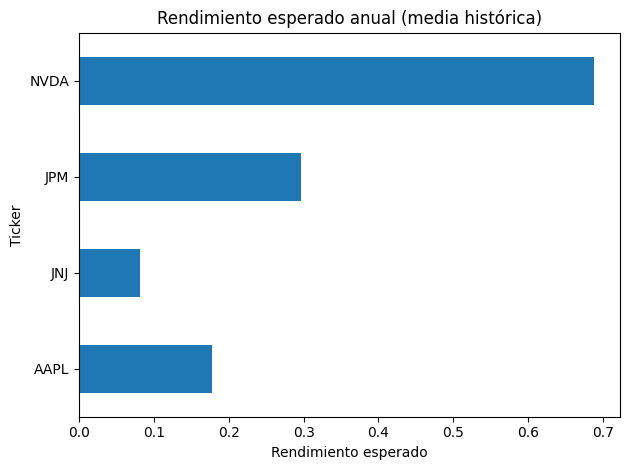

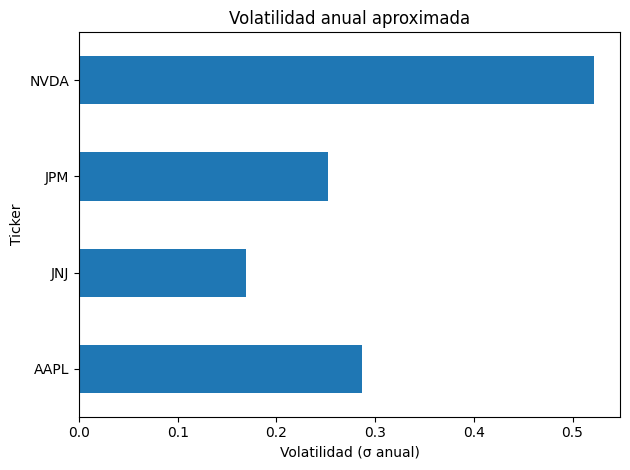

In [6]:
# Gráfica de rendimiento esperado anual
mu_hist.plot.barh(title="Rendimiento esperado anual (media histórica)")
plt.xlabel("Rendimiento esperado")
plt.tight_layout()

# Gráfica de volatilidad anual
plt.figure()
sigma_hist.plot.barh(title="Volatilidad anual aproximada")
plt.xlabel("Volatilidad (σ anual)")
plt.tight_layout()

mu ofrece una guía histórica; σ cuantifica riesgo. Úsalos como punto de partida, no como verdad absoluta.

### 4️⃣ Matriz de covarianza y heatmap.

### La matriz de covarianza es clave para calcular la varianza del portafolio y el efecto de diversificación.

### Fórmula (varianza de portafolio):
## $$\sigma_p^2 = w^\top \Sigma w$$

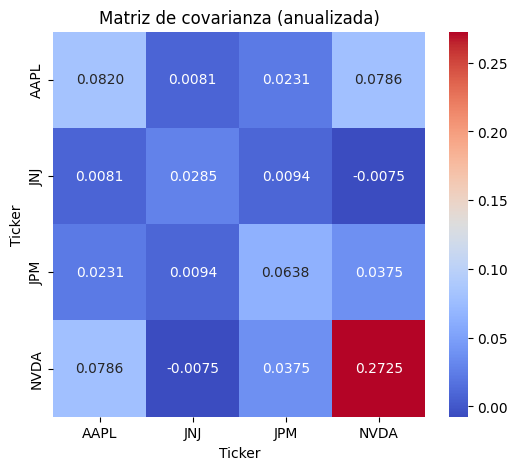

In [7]:
# Matriz de covarianza anualizada (sample covariance)
S = risk_models.sample_cov(prices, frequency=252)
plt.figure(figsize=(6,5))
sns.heatmap(S.round(6), annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Matriz de covarianza (anualizada)")
plt.show()

Valores altos positivos → activos se mueven juntos; negativos → se mueven en direcciones opuestas. Identifica pares con riesgo conjunto.

### 5️⃣ Frontera eficiente y portafolio de máximo Sharpe.

### La frontera eficiente muestra los portafolios óptimos (mínima varianza para cada retorno). El Ratio de Sharpe compara exceso de retorno por unidad de riesgo.

### Fórmula (Sharpe):
## $$ S = \frac{E[R_p] - R_f}{\sigma_p} $$

#### Regla práctica de interpretación:
#### S > 1: excelente

#### 0.5< S ≤1: bueno

#### 0< S ≤0.5: modesto

#### S ≤ 0: bajo o negativo

In [8]:
# Construir el objeto EfficientFrontier
ef = EfficientFrontier(mu_hist, S)
risk_free_rate = 0.0416

# Encontrar la cartera de máximo Sharpe.
raw_weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe = ef.clean_weights()
print(f"Pesos (Máximo Sharpe con Rf={risk_free_rate*100}%): {weights_max_sharpe}")

# Imprimir las métricas del portafolio óptimo.
print("\nMétricas del Portafolio Óptimo:")
ret_ms, vol_ms, sharpe_ms = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Pesos (Máximo Sharpe con Rf=4.16%): OrderedDict({'AAPL': 0.0, 'JNJ': 0.18068, 'JPM': 0.46374, 'NVDA': 0.35558})

Métricas del Portafolio Óptimo:
Expected annual return: 39.7%
Annual volatility: 24.9%
Sharpe Ratio: 1.43


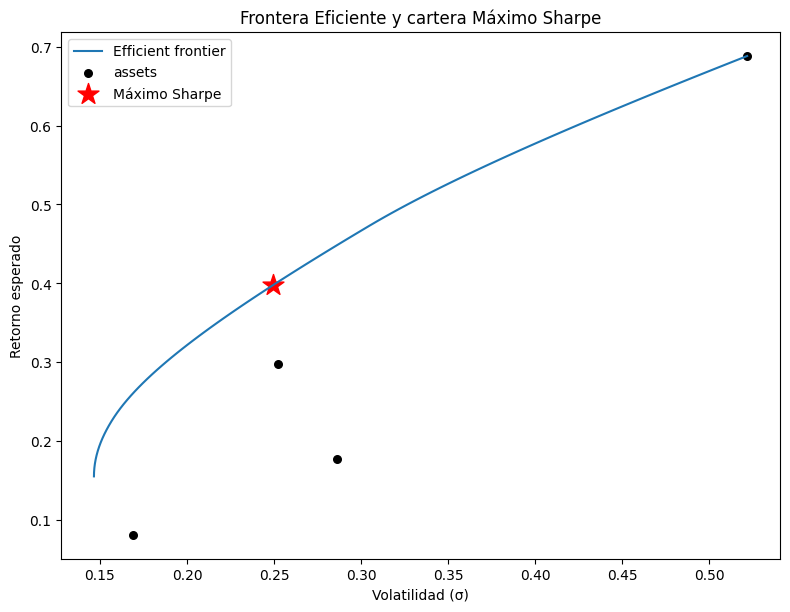

In [9]:
# Graficar
from pypfopt import plotting
plt.figure(figsize=(8,6))

ef_plot = EfficientFrontier(mu_hist, S)

plotting.plot_efficient_frontier(ef_plot, show_assets=True)

plt.scatter(vol_ms, ret_ms, marker="*", s=250, c="r", label="Máximo Sharpe")
plt.xlabel("Volatilidad (σ)")
plt.ylabel("Retorno esperado")
plt.title("Frontera Eficiente y cartera Máximo Sharpe")
plt.legend()
plt.show()

Muestra de forma visual por qué esa combinación de pesos es atractiva: máximo retorno por unidad de riesgo asumida.

### 6️⃣ Cartera mínima volatilidad para objetivo 20% y plan de compra para $10,000

### Encontrar los pesos que minimizan volatilidad sujeto a un retorno objetivo anual del 20%. Luego transformamos porcentajes a órdenes para $10,000.

### (Ejemplo practico)

In [10]:
# Intentar encontrar pesos para target return
target_return = 0.20

ef_target = EfficientFrontier(mu_hist, S)
try:
    weights_target = ef_target.efficient_return(target_return=target_return)
    weights_target = ef_target.clean_weights()
    print("Pesos (mín riesgo para target 20%):", weights_target)
    ret_t, vol_t, sharpe_t = ef_target.portfolio_performance(verbose=True)
except Exception as e:
    print("No fue posible encontrar una cartera que cumpla exactamente el target:", e)

Pesos (mín riesgo para target 20%): OrderedDict({'AAPL': 0.03939, 'JNJ': 0.62223, 'JPM': 0.23037, 'NVDA': 0.10802})
Expected annual return: 20.0%
Annual volatility: 15.1%
Sharpe Ratio: 1.33


In [11]:
# Distribucion del portafolio por posiciones.
latest_prices = get_latest_prices(prices)

total_value = 10000
da = DiscreteAllocation(weights_target, latest_prices, total_portfolio_value=total_value)
allocation, leftover = da.lp_portfolio()
print("Plan de compra (inversión $10,000):")
print(allocation)
print(f"Dinero sobrante: ${leftover:.2f}")

Plan de compra (inversión $10,000):
{'AAPL': 1, 'JNJ': 34, 'JPM': 7, 'NVDA': 6}
Dinero sobrante: $68.37


Mostramos número de acciones por ticker y cuánto dinero queda sin invertir.

### 7️⃣ CAPM: estimar retornos esperados usando S&P 500 y optimizar Sharpe.

### En vez de usar medias históricas, estimamos retornos esperados a través del CAPM, que ajusta expectativas por beta frente al mercado (S&P500).

### Fórmula (CAPM):
## $$
E[R_i] = R_f + \beta_i \left( E[R_m] - R_f \right)
$$

## $$
\beta_i = \frac{\mathrm{Cov}(R_i, R_m)}{\mathrm{Var}(R_m)}
$$


In [12]:
# Descargar S&P 500
market = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=True)["Close"]

# Rendimientos diarios
ret_assets = prices.pct_change().dropna()
ret_market = market.pct_change().dropna()

# Alinear fechas
ret_market.name = "^GSPC"
ret_data = ret_assets.join(ret_market, how="inner")
ret_assets = ret_data[tickers]
ret_market = ret_data["^GSPC"]

# Beta para cada activo
cov_with_market = ret_assets.apply(lambda x: x.cov(ret_market))
var_market = ret_market.var()
betas = cov_with_market / var_market

# Parámetros para CAPM
rf_annual = 0.0416
market_annual_return = expected_returns.mean_historical_return(market, frequency=252).iloc[0]
capm_mu = rf_annual + betas * (market_annual_return - rf_annual)
capm_mu.name = "CAPM_mu"
print("Betas:\n", betas.round(4))
print("\nRetornos esperados (CAPM, anual):\n", capm_mu.round(4))

[*********************100%***********************]  1 of 1 completed

Betas:
 Ticker
NVDA    2.1249
JNJ     0.2441
AAPL    1.2648
JPM     0.9063
dtype: float64

Retornos esperados (CAPM, anual):
 Ticker
NVDA    0.2682
JNJ     0.0676
AAPL    0.1765
JPM     0.1382
Name: CAPM_mu, dtype: float64


In [13]:
ef_capm = EfficientFrontier(capm_mu, S)
ef_capm.max_sharpe()
weights_capm = ef_capm.clean_weights()
print("Pesos (Max Sharpe usando CAPM mu):", weights_capm)
ret_c, vol_c, sharpe_c = ef_capm.portfolio_performance(verbose=True)

Pesos (Max Sharpe usando CAPM mu): OrderedDict({'NVDA': 0.50094, 'JNJ': 0.19724, 'AAPL': 0.30182, 'JPM': 0.0})
Expected annual return: 20.1%
Annual volatility: 19.3%
Sharpe Ratio: 1.04


CAPM trae una expectativa teórica basada en relación con el mercado. Puede moderar o amplificar retornos según el beta particular de los activos.

### 8️⃣ Convertir cartera CAPM-MaxSharpe en plan de compra para $10,000

### Transformar pesos continuos a órdenes reales con presupuesto $10,000

In [14]:
# Obtener últimos precios actualizados
latest_prices = get_latest_prices(prices)

total_value_10k = 10000
da_10k = DiscreteAllocation(weights_capm, latest_prices, total_portfolio_value=total_value_10k)
alloc_10k, leftover_10k = da_10k.lp_portfolio()
print("Plan de compra (inversión $10,000):")
print(alloc_10k)
print(f"Dinero sobrante: ${leftover_10k:.2f}")

Plan de compra (inversión $10,000):
{'NVDA': 19, 'JNJ': 10, 'AAPL': 10}
Dinero sobrante: $149.49


### 9️⃣ Interpretaciones prácticas y advertencias.

### Modelos y supuestos: todo depende de datos históricos y supuestos (rf, ventana, frecuencia). Revisa sensibilidad.

### Target del 20%: objetivo agresivo; la solución puede implicar alta volatilidad y concentración.

### DiscreteAllocation: resuelve el problema de enteros, pero puede dejar sobrante no invertido; revisa comisiones.

### CAPM vs histórico: CAPM incorpora relación con mercado; puede ser más conservador si betas < 1.

### Riesgo real: modelos no capturan eventos extremos (cisnes negros). Complementa con stress testing y juicio humano.

### 🔟 Conclusión y extensiones.

### Resumen corto: Con pandas, yfinance y pypfopt puedes pasar de precios históricos a una cartera optimizada y luego a un plan de compra real con pocos bloques de código. Esto reduce la fricción entre análisis y ejecución.

### Extensiones recomendadas:

### Backtesting de rebalanceos periódicos.

### Optimización con restricciones (límites por activo/sector, ESG).

### Uso de métricas alternativas (Sortino, drawdown constraints).

### Simulaciones Monte Carlo y stress tests.

Descargo de responsabilidad:

Este artículo es puramente informativo y no constituye asesoramiento financiero. No se recomienda tomar decisiones de inversión basadas únicamente en esta información. Se aconseja realizar un análisis propio y consultar a un profesional financiero antes de tomar decisiones de inversión. Las decisiones de inversión son responsabilidad exclusiva del lector.

En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.

● No es una asesoría financiera.

● No supone en ningún caso, esto sea recomendación de inversión, de compra o de venta de ningún activo/bien o subyacente.

● El contenido del articulo es meramente informativo.

● En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.